In [1]:
"""
OBJETIVO : Dividir los datasets princiaples en peuqeños datasets mas selectos, o solo modificaciones de los principales

TERMINOS: 
- DA = Data augmentation
- 01 = Datos entre 0 y 1
- 19 = Datos mayor a 1
- FDA = False data augemntation, consiste en cambiar el valor de preciptiacion para convertirlo de conforme a malo-
        
"""
Autor='Diego Paredes'

In [2]:
# Leer imagenes satelitales (.nc) 
from netCDF4 import Dataset, num2date

# Graficos y visualizaciones
import cartopy.crs as ccrs
import cartopy.feature as cfw
import matplotlib.pyplot as plt

# Liberias para manejo de datos
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

# Liberias estandar
import re
import time
import os

In [3]:
"""
DEFINIMOS EL PATH DEL PROYECTO 
"""
with open('../../path_base.txt') as f:
    path_base = f.read()
path_base

'C:/Users/Shounen/Desktop/Ciclo XI/Tesis 2/NewTesis'

In [4]:
#Nombre de archivos
#dfLimpio.to_csv(f'{p["path_base"]}/Archivos/Dataset/{p["redTipo"]}/{p["nameDS"]}_CompletoDS.csv')
#_dsTest.to_csv(f'{p["path_base"]}/Archivos/Dataset/{p["redTipo"]}/Pruebas/{p["nameDS"]}_PruebasDS.csv')
#_dsValid.to_csv(f'{p["path_base"]}/Archivos/Dataset/{p["redTipo"]}/Validacion/{p["nameDS"]}_ValidacionDS.csv')
#_dsTrain.to_csv(f'{p["path_base"]}/Archivos/Dataset/{p["redTipo"]}/Entrenamiento/{p["nameDS"]}_TrainDS.csv')

In [5]:
"""
Variables generales
"""
path_imagenes = 'F:/GOES/' 

# Archivos de datasets
dsName = 'dsCompletoPP_V2'

#Variables generales
products = ['C07','C08','C13']
times   = ['10','20','30','40','50','00']

In [6]:
#Archivos adicionales
Festaciones = f'{path_base}/Archivos/Inicial/estaciones.csv'
FflagV2 = f'{path_base}/Archivos/Dataset/dsFLAGV2.csv'

imagenTest = 'F:/GOES/C08/2021/01/G16_C08_Cyl_20210101-0020.nc'
Fanalisis = f'{path_base}/Archivos/Reportes/Datos/analisis_Total.csv'

In [7]:
def visualizarEstaciones(df, name = '',imagenTest='', xCode=True, row='codigo'):
    if not imagenTest:
        imagenTest = 'F:/GOES/C08/2021/01/G16_C08_Cyl_20210101-0020.nc'
    
    ds = Dataset(imagenTest)
    field = ds.variables['CMI'][:].data.astype(np.float32)/100.0

    # obtiene las coordenadas de los pixeles
    lons = ds.variables['longitude'][:].data
    lats = ds.variables['latitude'][:].data
    #lons, lats = np.meshgrid(lons, lats)
    
    Festaciones = f'{path_base}/Archivos/Inicial/estaciones.csv'
    dfEstaciones = pd.read_csv(Festaciones)
    dfCod = df[row].unique()
    dfCod = pd.DataFrame({row:dfCod.tolist()})

    #Graficomos las estaciones para el ds de regresion
    ax = plt.axes(projection=ccrs.PlateCarree())
    plt.title(f'{name} - Peru ({len(dfCod)} estaciones)')
    ax.set_extent([lons.min(), lons.max(), lats.min(),lats.max()], ccrs.PlateCarree())

    for x in dfCod.index:
        if xCode:
            st = dfEstaciones[dfEstaciones['CODE'] == f'X{dfCod[row][x]}']
        else:
            st = dfEstaciones[dfEstaciones['CODE'] == f'{dfCod[row][x]}']    
        if not st.empty:    
            x = st['LON']#.iloc[0]
            y = st['LAT']#.iloc[0]
            plt.plot(x, y,  1, marker='o', color='red',alpha=0.45)    

    ax.coastlines(resolution='110m')
    
    plt.savefig(f'{path_base}/Archivos/Reportes/Plots/MAPA_{name}.png')
    plt.show()

In [8]:
def statsDS(df, name='ds', tipo='Clasificacion'):    
    print(f'           ESTADISCIAS DEL {name} \n')  
    print(f'Flags       : {df["flag"].unique()}')
    print(f'Estaciones  : {len(df["codigo"].unique())}')
    print(f'Totales     : {df["dato"].count()}')
    print(f'Ceros       : {df[df["dato"]==0]["dato"].count()}')    
    if tipo=='Regresion':
        print(f'Menor a 1   : {df[df["dato"]<1]["dato"].count()}')
        print(f'Mayor a 1   : {df[df["dato"]>1]["dato"].count()}')
    else:
        print(f'Clase 0(M02): {df[df["flag"]=="M0000002"]["dato"].count()}')
        print(f'Clase 1(C02): {df[df["flag"]=="C0000002"]["dato"].count()}')
    print(f'Maximo      : {df["dato"].max()}')
    print(f'Media       : {df["dato"].mean()}')
    print(f'STD         : {df["dato"].std()}')

    #_dataset[_dataset["dato"]!=0]["dato"].hist(legend=True)
    #_dataset[_dataset["dato"]>1]["dato"].hist(legend=True)
    if tipo=='Clasificacion':
        df['flag'].hist(legend=True)
        plt.xlabel('FLAG')
        plt.ylabel('Cantidad')
        plt.title('Histograma de FLAG')
    else:
        df['dato'].hist(legend=True)   
        plt.xlabel('Valor')
        plt.ylabel('Cantidad')
        plt.title('Histograma de Precipitacion')
    plt.show()

In [9]:
"""
Metodos para balancear las clases en los datasets
"""

'\nMetodos para balancear las clases en los datasets\n'

In [10]:
# Aplica data augmentation en un df, aumentando solo la clase (columna) minoritaria maximo 3 (DA) veces
def applyDA(df, columna='clase', DA=3):
    df['DA'] = 0
    dfs = [df[df[columna]==0], df[df[columna]==1]]    
    posM = 0 if len(dfs[0])>len(dfs[1]) else 1
    
    # Clase minoritaria = M^1
    # Se va aumentar lm
    dfMenor0 = dfs[posM^1].copy()
    
    dfMenor1 = dfs[posM^1].copy()
    dfMenor1['DA'] = 1
    
    dfMenor2 = dfs[posM^1].copy()
    dfMenor2['DA'] = 2
    
    dfMenor3 = dfs[posM^1].copy()
    dfMenor3['DA'] = 3
    
     
    dfMenos = [dfMenor0,dfMenor1,dfMenor2,dfMenor3,dfs[posM]]
    train = pd.concat(dfMenos)    
    
    return train

In [11]:
# Aplica false data augmentation en un df, aumentando solo la clase (columna) minoritaria 
# hasta alcanzar el FDA porciento de la clase mayoritaria
# Si delete = True, lo convertido de la clase mayoritaria, se borra de la clase mayoritaria
def applyFA(df, columna='clase', FDA=1, umbralSep = 20, delete=False , porcAlta = 10):  
    # No se le aplicado DFA al dataset
    df['DFA'] = 0
    
    # Encontramos la clase mayoritaria y minoritaria
    dfs = [df[df[columna]==0], df[df[columna]==1]]
    posM = 0 if len(dfs[0])>len(dfs[1]) else 1
    
    # Calculamos cuantos datos se necesitan aplicar DFA
    cantFinal = FDA * len(dfs[posM])
    cantActual = len(dfs[posM^1])
    if delete:
        cantNeeded = (cantFinal - cantActual) / 2
    else:
        cantNeeded = cantFinal - cantActual
    
    # Calculamos los grupos de preciptiacion leve y fuerte en la clase mayoritaria
    dfLeve = dfs[posM].copy()
    dfLeve = dfLeve[dfLeve['dato']<1]
    cantLeve = (len(dfLeve))/len(dfs[posM]) * cantNeeded
    
    dfAlta = dfs[posM].copy()
    dfTemp = dfAlta[(dfAlta['dato']<=umbralSep) & (dfAlta['dato']>=1)]
    dfAlta = dfAlta[dfAlta['dato']>umbralSep]    
    cantAlta = (len(dfAlta))/len(dfs[posM]) * cantNeeded
    
    print(f'Cantidad de clase mayoritaria : {len(dfs[posM])}')
    print(f'Cantidad de clase minoritaria : {len(dfs[posM^1])}')
    print(f'Total a aumentar              : {cantNeeded}')
    print(f'Cantidad leve                 : {len(dfLeve)}')
    print(f'Cantidad alta                 : {len(dfAlta)}')
    
    
    fracA = int(cantNeeded/len(dfs[posM]) * len(dfAlta))   
    fracL = int(cantNeeded/len(dfs[posM]) * len(dfAlta)) * porcAlta
    
    # Obtenemso el DS de DFA
    if delete:
        
        print(f'Cantidad a tomar de leve      : {fracL}')
        dfDFAleve, tempL = train_test_split(dfLeve, train_size = fracL)# dfLeve.sample(frac=fracL)
    else:
        dfDFAleve = dfLeve.sample(n=int(cantLeve))
    
    dfDFAleve['dato'] = dfDFAleve['dato'] + umbralSep
    dfDFAleve['clase'] = 0
    dfDFAleve['flag'] = 'M0000002'
    dfDFAleve['DFA'] = 1
    
    if delete:      
        print(f'Cantidad a tomar de alto      : {fracA}')
        dfDFAAlto, tempA  = train_test_split(dfAlta, train_size =fracA )#dfAlta.sample(n=int(cantAlta))
    else:
        dfDFAAlto = dfAlta.sample(n=int(cantAlta))
    
    dfDFAAlto['dato'] = dfDFAAlto['dato'] - umbralSep
    dfDFAAlto['clase'] = 0
    dfDFAAlto['flag'] = 'M0000002'
    dfDFAAlto['DFA'] = 1
    
    
    
    if delete:
        train = pd.concat([tempA,tempL,dfTemp,dfDFAleve,dfDFAAlto,dfs[posM^1]])
        print(f'Diferencia final              : { len(dfDFAleve) + len(dfDFAAlto) - len(tempA) - len(tempL) - len(dfs[posM^1])}')
    else:
        train = pd.concat([dfs[posM],dfs[posM^1],dfDFAleve,dfDFAAlto])
        print(f'Diferencia final              : { len(dfs[posM]) - len(dfs[posM^1]) - (int(cantLeve) + int(cantAlta))}')
        
    return train

In [12]:
# Metodo de eliminar datos de la clase mayoritaria, elimna datos manteneindo el balance en lso niveles de precipitacion
def disminuirMayoritario(df, porc=0.2, umbralSep = 1, columna='clase'):
    dfs = [df[df[columna]==0], df[df[columna]==1]]
    posM = 0 if len(dfs[0])>len(dfs[1]) else 1
    
    # Calculamos los grupos de preciptiacion leve y fuerte en la clase mayoritaria
    dfLeve = dfs[posM].copy()
    dfLeve = dfLeve[dfLeve['dato']<umbralSep]    
    
    dfAlta = dfs[posM].copy()    
    dfAlta = dfAlta[dfAlta['dato']>=umbralSep]    
    
    dfDFLeve = dfLeve.sample(frac=porc)
    dfDFAlta = dfAlta.sample(frac=porc)
    
    train = pd.concat([dfDFLeve,dfDFAlta,dfs[posM^1]])
    
    return train

In [13]:
# Aplica el metodo de split, ademas este split se realiza tambien balanceando los niveles de precipiacion en cada grupo
def splitTrainDS(_dataset, redTipo, path_base, newDir='Split', DA=0, comentario=' '):      
    tipo = redTipo[0]
    output = redTipo[1]
    if DA:
        print('Se le aplicará DA al dataset')
        _dataset = applyDA(_dataset, output, 3)
        
    dfs = [_dataset[_dataset[output]==0], _dataset[_dataset[output]==1]]    
    posM = 0 if len(dfs[0])>len(dfs[1]) else 1
    lM = len(dfs[posM])
    lm = len(dfs[posM^1])
    
    try:
        path = os.path.join(f'{path_base}/Archivos/Dataset/{tipo}/Entrenamiento/', newDir)
        os.mkdir(path)        
    except FileExistsError:
        pass
    except:
        print(f"No se pudo crear la carpeta {newDir}")
    
    
    n = int(lM/lm) + (lM % lm > 0)    
    splitted = []
    
    for i in range(n):
        if i == (n-1):
            tempDF1 = dfs[posM][i*lm:i*lm+lm]
            tempDF2 = dfs[posM][0:i*lm].sample(n=(lm-len(tempDF1)))            
            splitted.append(pd.concat([tempDF1,tempDF2,dfs[posM^1]], ignore_index=True))            
        else:
            tempDF = dfs[posM][i*lm:i*lm+lm]            
            splitted.append(pd.concat([tempDF,dfs[posM^1]], ignore_index=True))
            
    print(f'Se ha divido el dataset en {len(splitted)} partes')
    i = 0    
    for df in splitted:        
        df.to_csv(f'{path_base}/Archivos/Dataset/{tipo}/Entrenamiento/{newDir}/{output.upper()}_TrainDS_{i}.csv')
        i+=1
 
    text_comentario = open(f'{path_base}/Archivos/Dataset/{tipo}/Entrenamiento/{newDir}/comentario.txt', "w")
    text_comentario.write(comentario) 
    text_comentario.close()
    
    return splitted

In [14]:
# Metodo auxiliar que elimina ceros hasta obtener el porcentaje deseado de ceros (porc)
def disminuirCeros(df, porc=0.2, columna='clase'):    
    cerosC02 = df[(df[columna]==1) & (df['dato']==0)]
    cerosM02 = df[(df[columna]==0) & (df['dato']==0)]
    
    cerosC02 = cerosC02.sample(frac=porc)
    cerosM02 = cerosM02.sample(frac=porc)
    
    dfSinCeros = df[df['dato']!=0]
    
    train = pd.concat([dfSinCeros, cerosC02, cerosM02])
    return train    

In [16]:
# Leemos el datasets de entrenamiento Clasifiacion
dsV_ = 'ClaseV2_DUD_TrainDS.csv'
fileTrain_DUD_DS = f'{path_base}/Archivos/Dataset/Clasificacion/Entrenamiento/{dsV_}'
fileTrain_V2_DS = f'{path_base}/Archivos/Dataset/Clasificacion/Entrenamiento/ClaseV2_TrainDS.csv'
fileVal = f'{path_base}/Archivos/Dataset/Clasificacion/Validacion/ClaseV2_DUD_ValidacionDS.csv'
filePrueba = f'{path_base}/Archivos/Dataset/Clasificacion/Pruebas/ClaseV2_DUD_PruebasDS.csv'

dsTrainCLAS_V2 = pd.read_csv(fileTrain_V2_DS)
dsTrainCLAS_DUD = pd.read_csv(fileTrain_DUD_DS)
dsValCLAS_DUD = pd.read_csv(fileVal)
dsPruebaCLAS_DUD = pd.read_csv(filePrueba)

<AxesSubplot:>

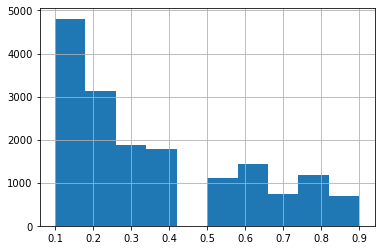

In [24]:
dsTrainCLAS_DUD[dsTrainCLAS_DUD['dato']<1]['dato'].hist()

In [ ]:
#statsDS(dsTrainCLAS_V2, name='CONJUNTO DE DATOS', tipo='Clasificacion')

In [17]:
#statsDS(dsTrainCLAS_DUD[dsTrainCLAS_DUD['clase']==1], name='CONJUNTO DE DATOS', tipo='Regresion')

In [18]:
#dsTrainCLAS_DUD['flag'].hist()
#statsDS(DUDTrain_DA_DFAD[DUDTrain_DA_DFAD['clase']==0], name='CONJUNTO DE DATOS', tipo='Regresion')

In [ ]:
"""
DS_V2: Diminuir ceros al 20% + DA + DFAD + split
"""

Se ha divido el dataset en 2 partes
           ESTADISCIAS DEL SplitConDA_C20POR_DM_V2 

Flags       : ['M0000002' 'C0000002']
Estaciones  : 141
Totales     : 6140
Ceros       : 1248
Clase 0(M02): 3070
Clase 1(C02): 3070
Maximo      : 337.5
Media       : 4.084195439739413
STD         : 27.76920410424823


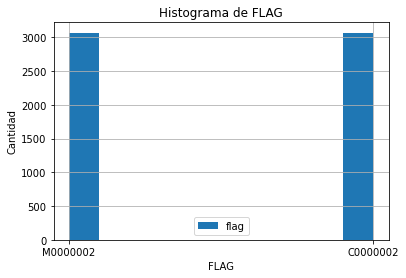

In [71]:
# DS CLasificacion, sin DA 
com_V2_DM_DA_DFAD = f"Clase V2 , Este dataset es para el modelo de clasificacion con output clase, SI se le esta aplicando DataAugmentation (DA). \
                al dataset se divide en varias partes de tal forma de balancear las clases. \
              SOLO uso el datasset clas_dud como base. \
              delete =True, proporcion a tomar de alto - leve = 1 - 1 y DM = 0.1, ceros = 20%"


V2Train_20C = disminuirCeros(dsTrainCLAS_V2, porc=0.2, columna='clase')
V2Train_20C_DA = applyDA(V2Train_20C, columna='clase', DA=3)
#V2Train_20C_DA_DFAD = applyFA(V2Train_20C_DA, columna='clase', FDA=0.05, umbralSep = 20, delete=True, porcAlta = 1)
V2Train_20C_DA_DM = disminuirMayoritario(V2Train_20C_DA, porc=0.1)
    
splittedDF_DUD_DA_DM = splitTrainDS(V2Train_20C_DA_DM,['Clasificacion','clase'], path_base, newDir='SplitConDA_C20POR_DM_V2', DA= 0, comentario=com_V2_DM_DA_DFAD) 

# Visualimamos un datasets
#visualizarEstaciones(splittedDF_DUD_DA_DM_DFAD[0], name = 'SplitConDA_DM_DFAD_20C_V1',xCode=True, row='codigo')
statsDS(splittedDF_DUD_DA_DM[0], name='SplitConDA_C20POR_DM_V2')

In [ ]:
"""
DS_V2: Diminuir ceros al 10% + DA + DFAD + split
"""

Se ha divido el dataset en 2 partes
           ESTADISCIAS DEL SplitConDA_DM_20C_V2 

Flags       : ['M0000002' 'C0000002']
Estaciones  : 142
Totales     : 6008
Ceros       : 622
Clase 0(M02): 3004
Clase 1(C02): 3004
Maximo      : 337.5
Media       : 4.2079127829560585
STD         : 28.06618251389613


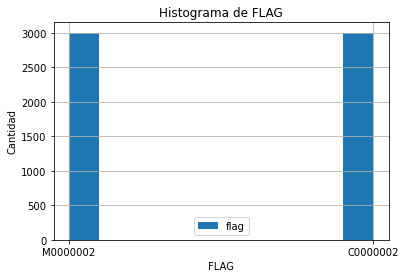

In [52]:
# DS CLasificacion, sin DA 
com_V2_DM_DA_DFAD = f"Clase V2 , Este dataset es para el modelo de clasificacion con output clase, SI se le esta aplicando DataAugmentation (DA). \
                al dataset se divide en varias partes de tal forma de balancear las clases. \
              SOLO uso el datasset clas_dud como base. \
              delete =True, proporcion a tomar de alto - leve = 1 - 1 y DM = 0.1, ceros = 10%"


V2Train_20C = disminuirCeros(dsTrainCLAS_V2, porc=0.1, columna='clase')
V2Train_20C_DA = applyDA(V2Train_20C, columna='clase', DA=3)
#V2Train_20C_DA_DFAD = applyFA(V2Train_20C_DA, columna='clase', FDA=0.05, umbralSep = 20, delete=True, porcAlta = 1)
V2Train_20C_DA_DM = disminuirMayoritario(V2Train_20C_DA, porc=0.1)
    
splittedDF_DUD_DA_DM = splitTrainDS(V2Train_20C_DA_DM,['Clasificacion','clase'], path_base, newDir='SplitConDA_20C_DM_V2', DA= 0, comentario=com_V2_DM_DA_DFAD) 

# Visualimamos un datasets
#visualizarEstaciones(splittedDF_DUD_DA_DM_DFAD[0], name = 'SplitConDA_DM_DFAD_20C_V1',xCode=True, row='codigo')
statsDS(splittedDF_DUD_DA_DM[0], name='SplitConDA_DM_20C_V2')

In [53]:
for df in splittedDF_DUD_DA_DM:
    print(f'Estaciones  : {len(df["codigo"].unique())}')

Estaciones  : 142
Estaciones  : 142


In [ ]:
"""
Disminuir la clase Mayoritaria + DA + DFAD + Split
"""

Cantidad de clase mayoritaria : 28403
Cantidad de clase minoritaria : 1760
Total a aumentar              : 1960.3000000000002
Cantidad leve                 : 16424
Cantidad alta                 : 712
Cantidad a tomar de leve      : 49
Cantidad a tomar de alto      : 49
Diferencia final              : -18700
Se ha divido el dataset en 4 partes


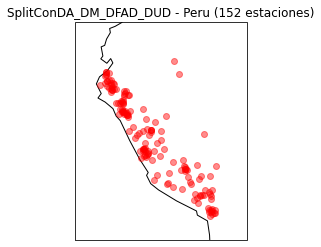

           ESTADISCIAS DEL SplitConDA_DM_DFAD_DUD 

Flags       : ['C0000002' 'M0000002']
Estaciones  : 144
Totales     : 3716
Ceros       : 0
Clase 0(M02): 1858
Clase 1(C02): 1858
Maximo      : 337.5
Media       : 8.2008853606028
STD         : 43.21833336863061


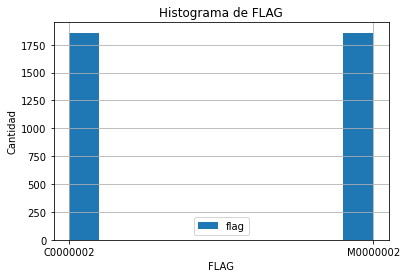

In [40]:
# DS CLasificacion, sin DA 
com_DUD_DM_DA_DFAD = f"Este dataset es para el modelo de clasificacion con output clase, SI se le esta aplicando DataAugmentation (DA). \
                al dataset se divide en varias partes de tal forma de balancear las clases. \
              SOLO uso el datasset clas_dud como base. FDA = 0.2,  Umbral de DFA =  10, \
              delete =True, proporcion a tomar de alto - leve = 1 - 1 y DM = 0.2"

DUDTrain_DA = applyDA(dsTrainCLAS_DUD, columna='clase', DA=3)
DUDTrain_DA_DFAD = applyFA(DUDTrain_DA, columna='clase', FDA=0.2, umbralSep = 10, delete=True, porcAlta = 1)
DUDTrain_DA_DM_DFAD = disminuirMayoritario(DUDTrain_DA_DFAD, porc=0.2)
    
splittedDF_DUD_DA_DM_DFAD = splitTrainDS(DUDTrain_DA_DM_DFAD,['Clasificacion','clase'], path_base, newDir='SplitConDA_DM_DFAD_DUD', DA= 0, comentario=com_DUD_DM_DA_DFAD) 

# Visualimamos un datasets
visualizarEstaciones(DUDTrain_DA_DFAD, name = 'SplitConDA_DM_DFAD_DUD',xCode=True, row='codigo')
statsDS(splittedDF_DUD_DA_DM_DFAD[0], name='SplitConDA_DM_DFAD_DUD')

In [39]:
for df in splittedDF_DUD_DA_DM_DFAD:
    print(f'Estaciones  : {len(df["codigo"].unique())}')

Estaciones  : 142
Estaciones  : 141
Estaciones  : 135
Estaciones  : 140


In [ ]:
"""
Aplicando DA , DFAD y Split
"""

Cantidad de clase mayoritaria : 28403
Cantidad de clase minoritaria : 1760
Total a aumentar              : 6220.75
Cantidad leve                 : 16424
Cantidad alta                 : 712
Cantidad a tomar de leve      : 3100
Cantidad a tomar de alto      : 155
Diferencia final              : -12386
Se ha divido el dataset en 6 partes


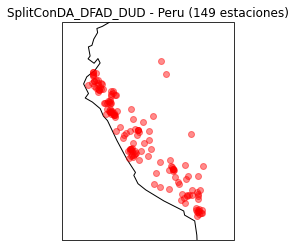

           ESTADISCIAS DEL SplitConDA_DFAD_DUD 

Flags       : ['C0000002' 'M0000002']
Estaciones  : 149
Totales     : 10030
Ceros       : 0
Clase 0(M02): 5015
Clase 1(C02): 5015
Maximo      : 337.5
Media       : 7.320242273180458
STD         : 26.789648921031468


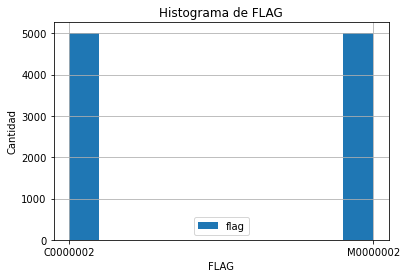

In [132]:
# DS CLasificacion, sin DA 
com_DUD_DA_DFAD = f"Este dataset es para el modelo de clasificacion con output clase, SI se le esta aplicando DataAugmentation (DA). \
                al dataset se divide en varias partes de tal forma de balancear las clases. \
              SOLO uso el datasset clas_dud como base. FDA = 0.5,  Umbral de DFA =  20, delete =True, proporcion a tomar de alto - leve = 20 - 1"

DUDTrain_DA = applyDA(dsTrainCLAS_DUD, columna='clase', DA=3)
DUDTrain_DA_DFAD = applyFA(DUDTrain_DA, columna='clase', FDA=0.5, umbralSep = 10, delete=True, porcAlta = 20)

splittedDF_DUD_DA_DFAD = splitTrainDS(DUDTrain_DA_DFAD,['Clasificacion','clase'], path_base, newDir='SplitConDA_DFAD_DUD', DA= 0, comentario=com_DUD_DA_DFAD) 

# Visualimamos un datasets
visualizarEstaciones(splittedDF_DUD_DA_DFAD[0], name = 'SplitConDA_DFAD_DUD',xCode=True, row='codigo')
statsDS(splittedDF_DUD_DA_DFAD[0], name='SplitConDA_DFAD_DUD')

In [133]:
for df in splittedDF_DUD_DA_DFAD:
    print(f'Estaciones  : {len(df["codigo"].unique())}')

Estaciones  : 149
Estaciones  : 146
Estaciones  : 148
Estaciones  : 147
Estaciones  : 148
Estaciones  : 149


In [ ]:
""" 
Aplicando DFA y  Split
"""

Cantidad de clase mayoritaria : 28403
Cantidad de clase minoritaria : 440
Total a aumentar              : 1402
Diferencia final              : 26561
Se ha divido el dataset en 16 partes


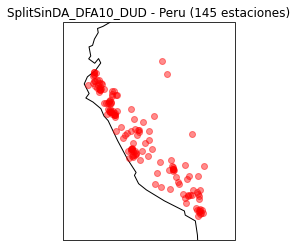

           ESTADISCIAS DEL SplitSinDA_DFA10_DUD 

Flags       : ['C0000002' 'M0000002']
Estaciones  : 145
Totales     : 3684
Ceros       : 0
Clase 0(M02): 1842
Clase 1(C02): 1842
Maximo      : 337.5
Media       : 9.853968512486428
STD         : 23.38765570476748


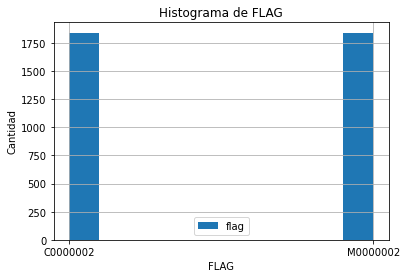

In [23]:
# DS CLasificacion, sin DA 
com_DUD = f"Este dataset es para el modelo de clasificacion con output clase, NO se le esta aplicando DataAugmentation (DA). \
              Solo se le esta aplicando DFA hasta igual el 10% del dataset mayoritario\
                al dataset se divide en varias partes de tal forma de balancear las clases. \
              SOLO uso el datasset clas_dud como base. Umbral de DFA =  20"

DUDTrain_DFA = applyFA(dsTrainCLAS_DUD, columna='clase', FDA=0.1, umbralSep = 20)
splittedDF_DUD = splitTrainDS(DUDTrain_DFA,['Clasificacion','clase'], path_base, newDir='SplitSinDA_DFA10_DUD', DA= 0, comentario=com_DUD) 

# Visualimamos un datasets
visualizarEstaciones(splittedDF_DUD[0], name = 'SplitSinDA_DFA10_DUD',xCode=True, row='codigo')
statsDS(splittedDF_DUD[0], name='SplitSinDA_DFA10_DUD')

In [18]:
for df in splittedDF_DUD:
    print(f'Estaciones  : {len(df["codigo"].unique())}')

Estaciones  : 146
Estaciones  : 144
Estaciones  : 147
Estaciones  : 146
Estaciones  : 147
Estaciones  : 144
Estaciones  : 144
Estaciones  : 145
Estaciones  : 147
Estaciones  : 146
Estaciones  : 145
Estaciones  : 146
Estaciones  : 147
Estaciones  : 146
Estaciones  : 145
Estaciones  : 145


In [120]:
""" 
Aplicando DA + DFA (Solo aumentado clase minoritaria)
"""

' \nAplicando DA + DFA (Solo aumentado clase minoritaria)\n'

Cantidad de clase mayoritaria : 28403
Cantidad de clase minoritaria : 1760
Total a aumentar              : 15566
Diferencia final              : 11077
Se ha divido el dataset en 2 partes


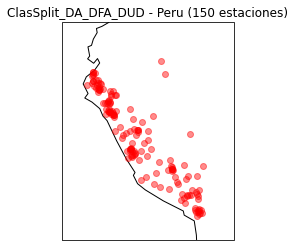

           ESTADISCIAS DEL ClasSplit_DA_DFA_DUD 

Flags       : ['C0000002' 'M0000002']
Estaciones  : 150
Totales     : 34652
Ceros       : 0
Clase 0(M02): 17326
Clase 1(C02): 17326
Maximo      : 337.5
Media       : 10.055985224518066
STD         : 16.622801032582892


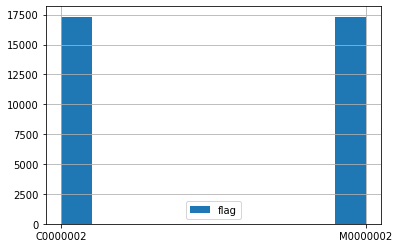

In [130]:
# Aplicamso DA al ds train
DUDTrain_DA = applyDA(dsTrainCLAS_DUD, columna='clase', DA=3)
#statsDS(DUDTrain_DA, name='Clas_DA_DUD')

# Aplicamos FDA hasta completar la clase mayoritaria
DUDTrain_DA_DFA = applyFA(DUDTrain_DA, columna='clase', FDA=1, umbralSep = 20)
#statsDS(DUDTrain_DA_DFA, name='Clas_DA__DFA_DUD')

# Realizmos el split para nivelar las clases
# DS CLasificacion, sin DA 
comDA_DFA_DUD = f"Este dataset es para el modelo de clasificacion con output clase, Se le ha aplicaod DA, y luego FDA.\
             Sin embargo, ya que no se logro nivelar completamente las clases, se aplicará un split"
                

splittedDF_DUD_DA_DFA = splitTrainDS(DUDTrain_DA_DFA,['Clasificacion','clase'], path_base, newDir='SplitConDA_DFA_DUD', DA= 0, comentario=comDA_DFA_DUD) 

# Visualimamos un datasets
visualizarEstaciones(splittedDF_DUD_DA_DFA[0], name = 'ClasSplit_DA_DFA_DUD',xCode=True, row='codigo')
statsDS(splittedDF_DUD_DA_DFA[0], name='ClasSplit_DA_DFA_DUD')

In [ ]:
"""
Split para dataset de clasificacion DUD (Usando FDA)
"""

In [ ]:
# DS CLasificacion, sin DA 
comDA_DUD = f"Este dataset es para el modelo de clasificacion con output clase, SI se le esta aplicando DataAugmentation (DA). \
              al dataset se divide en varias partes de tal forma de balancear las clases. \
              Datset original usado : {fileDS} V2: Analisis V2 - SOLO uso el datasset clas_dud como base"

splittedDF_DUD_DA = splitTrainDS(dsTrainCLAS_DUD,['Clasificacion','clase'], path_base, newDir='SplitConDA_DUD', DA= 3, comentario=comDA_DUD) 

# Visualimamos un datasets
visualizarEstaciones(splittedDF_DUD_DA[0], name = 'ClasSplit_DA_DUD',xCode=True, row='codigo')
statsDS(splittedDF_DUD_DA[0], name='ClasSplit_DA_DUD')

In [108]:
"""
Split para dataset de clasificacion DUD (Usando DA)
"""

'\nSplit para dataset de clasificacion DUD (Usando DA)\n'

Se le aplicará DA al dataset
Se ha divido el dataset en 17 partes


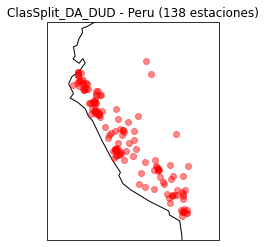

           ESTADISCIAS DEL ClasSplit_DA_DUD 

Flags       : ['C0000002' 'M0000002']
Estaciones  : 138
Totales     : 3520
Ceros       : 0
Clase 0(M02): 1760
Clase 1(C02): 1760
Maximo      : 337.5
Media       : 7.8031761363636365
STD         : 42.828279217547724


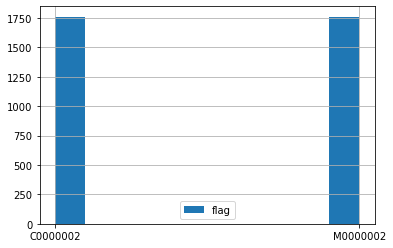

In [109]:
# DS CLasificacion, sin DA 
comDA_DUD = f"Este dataset es para el modelo de clasificacion con output clase, SI se le esta aplicando DataAugmentation (DA). \
              al dataset se divide en varias partes de tal forma de balancear las clases. \
              Datset original usado : {fileDS} V2: Analisis V2 - SOLO uso el datasset clas_dud como base"

splittedDF_DUD_DA = splitTrainDS(dsTrainCLAS_DUD,['Clasificacion','clase'], path_base, newDir='SplitConDA_DUD', DA= 3, comentario=comDA_DUD) 

# Visualimamos un datasets
visualizarEstaciones(splittedDF_DUD_DA[0], name = 'ClasSplit_DA_DUD',xCode=True, row='codigo')
statsDS(splittedDF_DUD_DA[0], name='ClasSplit_DA_DUD')

In [59]:
for df in splittedDF_DUD_DA:
    print(f'Estaciones  : {len(df["codigo"].unique())}')

Estaciones  : 138
Estaciones  : 141
Estaciones  : 141
Estaciones  : 140
Estaciones  : 142
Estaciones  : 139
Estaciones  : 140
Estaciones  : 141
Estaciones  : 141
Estaciones  : 143
Estaciones  : 126
Estaciones  : 124
Estaciones  : 130
Estaciones  : 131
Estaciones  : 127
Estaciones  : 129
Estaciones  : 136


In [ ]:
"""
Split para dataset de clasificacion V2 (Usando DA y sin DA)
"""

In [45]:
# Leemos el datasets de entrenamiento Clasifiacion
dsV_ = 'ClaseV2_TrainDS.csv'
fileDS = f'{path_base}/Archivos/Dataset/Clasificacion/Entrenamiento/{dsV_}'
dsTrainCLAS = pd.read_csv(fileDS)

Se ha divido el dataset en 15 partes


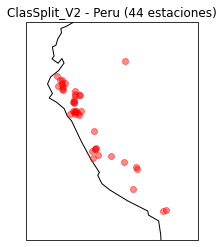

           ESTADISCIAS DEL ClasSplit_V2 

Flags       : ['C0000002' 'M0000002']
Estaciones  : 44
Totales     : 4988
Ceros       : 4330
Clase 0(M02): 2494
Clase 1(C02): 2494
Maximo      : 337.5
Media       : 1.395437048917402
STD         : 18.20983053084647


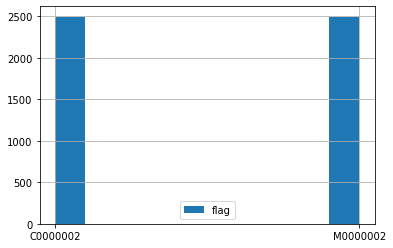

In [46]:
# DS CLasificacion, sin DA 
comDA = f"Este dataset es para el modelo de clasificacion con output clase, NO se le esta aplicando DataAugmentation (DA). \
              al dataset se divide en varias partes de tal forma de balancear las clases. Version 1\
              Datset original usado : {fileDS} V2: Analisis V2"

splittedDF = splitTrainDS(dsTrainCLAS,['Clasificacion','clase'], path_base, newDir='SplitSinDA_V2', DA= 0, comentario=comDA) 

# Visualimamos un datasets
visualizarEstaciones(splittedDF[0], name = 'ClasSplit_V2',xCode=True, row='codigo')
statsDS(splittedDF[0], name='ClasSplit_V2')

In [60]:
for df in splittedDF:
    print(f'Estaciones  : {len(df["codigo"].unique())}')

Estaciones  : 44
Estaciones  : 43
Estaciones  : 133
Estaciones  : 142
Estaciones  : 142
Estaciones  : 145
Estaciones  : 143
Estaciones  : 143
Estaciones  : 145
Estaciones  : 143
Estaciones  : 135
Estaciones  : 127
Estaciones  : 132
Estaciones  : 133
Estaciones  : 141


Se le aplicará DA al dataset
Se ha divido el dataset en 4 partes


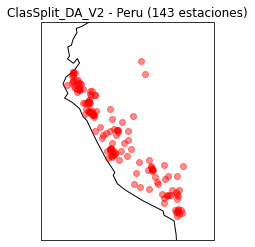

           ESTADISCIAS DEL ClasSplit_DA_V2 

Flags       : ['C0000002' 'M0000002']
Estaciones  : 143
Totales     : 19952
Ceros       : 14024
Clase 0(M02): 9976
Clase 1(C02): 9976
Maximo      : 337.5
Media       : 1.4583751002405771
STD         : 18.204542458216697


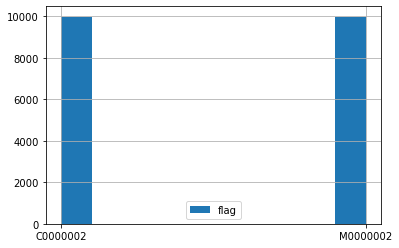

In [47]:
# DS CLasificacion, con DA 
comNODA = f"Este dataset es para el modelo de clasificacion con output clase, SI se le esta aplicando DataAugmentation (DA) = 3. \
              al dataset se divide en varias partes de tal forma de balancear las clases. Version 1\
              Datset original usado : {fileDS} V2: Analisis V2"

splittedDF_DA = splitTrainDS(dsTrainCLAS,['Clasificacion','clase'], path_base, newDir='SplitConDA_V2', DA= 3, comentario=comNODA)  

# Visualimamos un datasets
visualizarEstaciones(splittedDF_DA[0], name = 'ClasSplit_DA_V2',xCode=True, row='codigo')
statsDS(splittedDF_DA[0], name='ClasSplit_DA_V2')

In [61]:
for df in splittedDF_DA:
    print(f'Estaciones  : {len(df["codigo"].unique())}')

Estaciones  : 143
Estaciones  : 149
Estaciones  : 150
Estaciones  : 147


In [48]:
"""
Regresion, datasets entre 0 y 1
"""

'\nRegresion, datasets entre 0 y 1\n'

In [49]:
# Leemos el datasets de entrenamiento Regresion
dsV_ = 'REGV2_TrainDS.csv'
fileDS = f'{path_base}/Archivos/Dataset/Regresion/Entrenamiento/{dsV_}'
dsTrainREGV2 = pd.read_csv(fileDS)

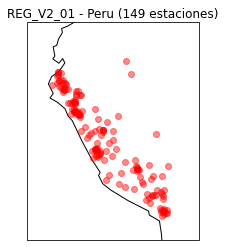

           ESTADISCIAS DEL REGV2_01 

Flags       : ['C0000002']
Estaciones  : 149
Totales     : 21250
Ceros       : 5938
Clase 0(M02): 0
Clase 1(C02): 21250
Maximo      : 0.9
Media       : 0.2512263529411765
STD         : 0.2614685230886519


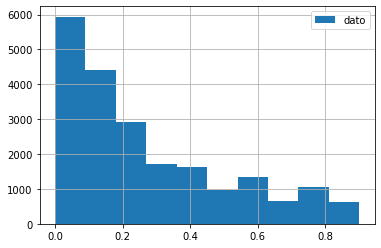

In [52]:
ds0_1 = dsTrainREGV2[dsTrainREGV2['dato']<1]
ds0_1.to_csv(f'{path_base}/Archivos/Dataset/Regresion/Entrenamiento/REGV2_Train01.csv')
# Visualimamos un datasets
visualizarEstaciones(ds0_1, name = 'REG_V2_01',xCode=True, row='codigo')
statsDS(ds0_1, name='REGV2_01' , tipo='Regresion')

In [51]:
"""
Regresion, datasets mayores a 1
"""

'\nRegresion, datasets mayores a 1\n'

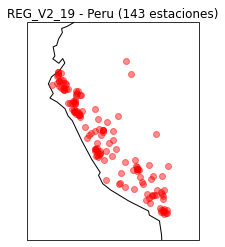

           ESTADISCIAS DEL REGV2_19 

Flags       : ['C0000002']
Estaciones  : 143
Totales     : 10006
Ceros       : 0
Clase 0(M02): 0
Clase 1(C02): 10006
Maximo      : 66.9
Media       : 3.7524405356785926
STD         : 4.435697211863565


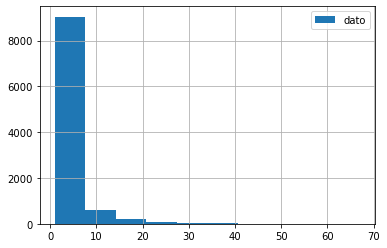

In [53]:
ds1_9 = dsTrainREGV2[dsTrainREGV2['dato']>1]
ds1_9.to_csv(f'{path_base}/Archivos/Dataset/Regresion/Entrenamiento/REGV2_Train19.csv')

# Visualimamos un datasets
visualizarEstaciones(ds1_9, name = 'REG_V2_19',xCode=True, row='codigo')
statsDS(ds1_9, name='REGV2_19' , tipo='Regresion')